In [1]:
import pandas as pd

In [2]:
from scipy.sparse import coo_matrix
import h5py
import logging
import numpy as np
import pandas as pd

def parse_go_hd5(filename):
    """
    Loads data in file to dataframe.
    """
    with h5py.File(filename, 'r') as f:
        col_uid = []
        logging.debug("reading matrix...")
        row = [ s.decode() for s in  f['GO'][:] ]
        columns = [ s.decode() for s in  f['genes'][:] ]
        matrix = f['ind'][:] - 1 #the indices in this matrix are stored from 1 
        coo = coo_matrix(( np.ones(1901323) , (matrix[0,:],matrix[1,:] )), shape=(len(columns), len(row)) )
        logging.debug("reading columns. converting to unicode")
        df = pd.DataFrame(coo.toarray(),  index=columns, columns = row )
        duplicates = df.index.duplicated(keep='first')
        df = df.loc[~duplicates, :]
    return df

def parse_expression_hd5_lee(filename):
    """
    Loads data in file to dataframe.
    """
    col_uid = []
    row_uid = []
    with h5py.File(filename, 'r') as f:
        logging.debug("reading matrix...")
        matrix = f['agg'][:]
        logging.debug("reading rows. converting to unicode.")
        rows = [ s.decode() for s in  f['row'][:] ]
        counter = 0
        for x in rows:
            try:
                x_o = x.split(".")[0]
                row_uid.append(x_o)
            except KeyError:
                counter = counter + 1
                row_uid.append('del')
        logging.debug("reading columns. converting to unicode")
        columns = [ s.decode() for s in  f['col'][:] ]
        for x in columns:
            try:
                x_o = x.split(".")[0]
                col_uid.append(x_o)
            except KeyError:
                col_uid.append('del')
        logging.debug("making dataframe...")
        df = pd.DataFrame(matrix,  index=row_uid, columns = col_uid)
    duplicates = df.index.duplicated(keep='first')
    df = df.loc[~duplicates, ~duplicates]


    return df 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=20, max_count=5000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P, predicts2

ModuleNotFoundError: No module named 'bottleneck'

In [3]:
go_df = parse_go_hd5("/data/johlee/CoCoCoNet/gene2go/human_gene2go.hdf5")

In [1]:
df_exp = ("/grid/gillis/data/lohia/hi_c_data_processing//software/CoCoCoNet/networks/human_prioAggNet.h5")

In [ ]:
exp_df = parse_expression_hd5_lee('/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5')


In [4]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

In [ ]:
SRP_name='aggregates'
resolution='40kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

jac_sim = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [7]:
df_2d, go_chrom  = run_egad(go_df, df_jac_corr)

(18163, 18163)
(18163, 22517)
0.9955355307154238
0.0


<ipython-input-6-a09629c0c213>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


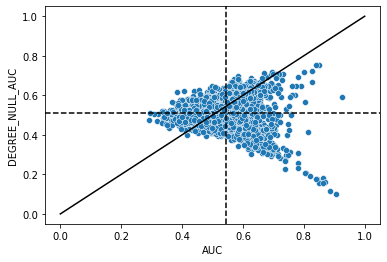

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d.merge(GO_groups, left_on = df_2d.index, right_on = 'go_id'), x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

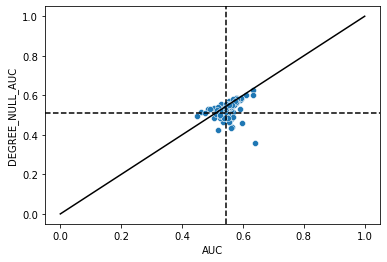

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d.merge(GO_groups, left_on = df_2d.index, right_on = 'go_id'), x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [11]:
df_2d.sort_values(by=['AUC'])

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value
GO:1902668  0.289716     5.303852e+08         0.474683   3.416203e-04
GO:0097228  0.294573     5.581519e+08         0.510882   4.346893e-04
GO:0070884  0.308098     5.564119e+08         0.505569   4.927183e-05
GO:0001223  0.318866     5.539843e+08         0.471247   1.801079e-03
GO:0008210  0.319677     5.620115e+08         0.505306   2.456851e-04
...              ...              ...              ...            ...
GO:0004984  0.864579     3.952832e+08         0.154928  3.410878e-136
GO:0033038  0.869992     4.058350e+08         0.162654   2.126415e-10
GO:0033141  0.887462     3.668120e+08         0.117878   3.191223e-10
GO:0005549  0.906251     3.576783e+08         0.101933   1.902395e-38
GO:0045095  0.926087     6.161674e+08         0.590445   1.344615e-45

[5769 rows x 4 columns]

In [25]:
df_2d.sort_values(by=['AUC'])

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value
GO:1902668  0.289716     5.303852e+08         0.474683   3.416203e-04
GO:0097228  0.294573     5.581519e+08         0.510882   4.346893e-04
GO:0070884  0.308098     5.564119e+08         0.505569   4.927183e-05
GO:0001223  0.318866     5.539843e+08         0.471247   1.801079e-03
GO:0008210  0.319677     5.620115e+08         0.505306   2.456851e-04
...              ...              ...              ...            ...
GO:0004984  0.864579     3.952832e+08         0.154928  3.410878e-136
GO:0033038  0.869992     4.058350e+08         0.162654   2.126415e-10
GO:0033141  0.887462     3.668120e+08         0.117878   3.191223e-10
GO:0005549  0.906251     3.576783e+08         0.101933   1.902395e-38
GO:0045095  0.926087     6.161674e+08         0.590445   1.344615e-45

[5769 rows x 4 columns]

In [21]:
GO_groups = pd.read_csv('/data/bharris/GO_data/aug4.GOslim', names=["go_id"])

In [26]:
df_2d.merge(GO_groups, left_on = df_2d.index, right_on = 'go_id').sort_values(by=['AUC'])

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC       P_Value       go_id
50   0.450544     5.576405e+08         0.497326  4.486572e-02  GO:0007009
24   0.463644     5.656650e+08         0.513147  7.471183e-02  GO:0005777
78   0.474405     5.563080e+08         0.509305  5.970698e-02  GO:0016798
34   0.486561     5.656480e+08         0.531313  8.741266e-02  GO:0006091
112  0.492190     5.688516e+08         0.528507  3.801154e-02  GO:0051186
..        ...              ...              ...           ...         ...
105  0.595793     5.333501e+08         0.457432  1.594813e-03  GO:0043473
89   0.610507     5.967787e+08         0.600706  1.955799e-07  GO:0022618
85   0.634184     6.041490e+08         0.602901  1.963445e-04  GO:0019843
61   0.634285     6.056378e+08         0.628836  1.713496e-05  GO:0008135
110  0.640136     4.953712e+08         0.360152  5.736581e-67  GO:0050877

[119 rows x 5 columns]

In [16]:
!ls /data/bharris/GO_data/

arabidopsis			GO_human_no_repl_fast.h5  old_go    syngo
aug4.GOslim			go_human_one_hot.csv	  R_data
go_annotation_descriptions.csv	GOmaize.csv		  reactome
GO_data				go_mouse_nw.hdf5	  syn_go


In [20]:
!more /data/bharris/GO_data/go_annotation_descriptions.csv

,X,X.1,X.2
1,GO:0000001,mitochondrion inheritance,biological_process
2,GO:0000002,mitochondrial genome maintenance,biological_process
3,GO:0000003,reproduction,biological_process
4,GO:0000005,obsolete ribosomal chaperone activity,molecular_function
5,GO:0000006,high-affinity zinc transmembrane transporter activity,molecular_fun
ction
6,GO:0000007,low-affinity zinc ion transmembrane transporter activity,molecular_
function
7,GO:0000008,obsolete thioredoxin,molecular_function
8,GO:0000009,alpha-1;6-mannosyltransferase activity,molecular_function
9,GO:0000010,trans-hexaprenyltranstransferase activity,molecular_function
10,GO:0000011,vacuole inheritance,biological_process
11,GO:0000012,single strand break repair,biological_process
12,GO:0000014,single-stranded DNA endodeoxyribonuclease activity,molecular_funct
ion
13,GO:0000015,phosphopyruvate hydratase complex,cellular_component
14,GO:0000016,lactase activity,molecular_function
15,GO:0000017,alpha-glucoside transport,biological_process
16

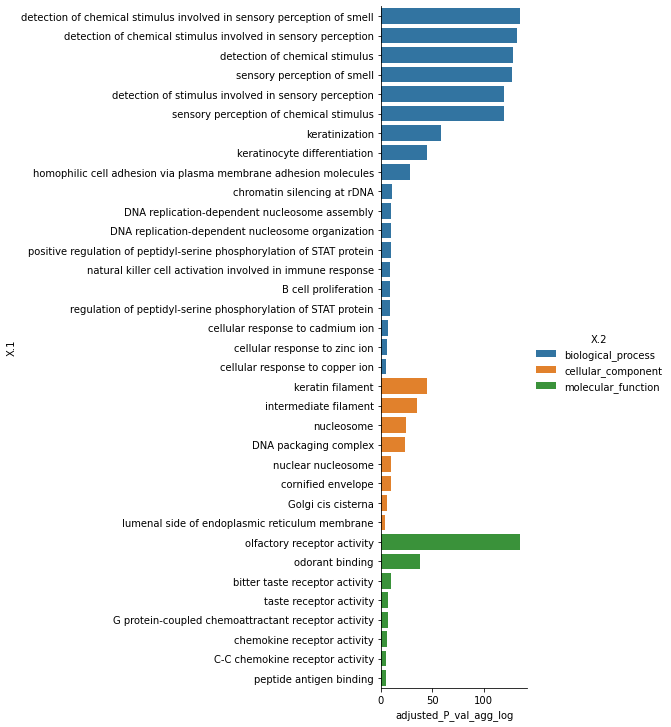

In [35]:

    

    df_whole = pd.read_csv('/data/bharris/GO_data/go_annotation_descriptions.csv').merge(df_2d, left_on='X', right_on=df_2d.index)

    df_whole['adjusted_P_val_agg_log'] = [-1*np.log10(x) for x in df_whole['P_Value']]
    sns.catplot(data=df_whole[df_whole['AUC'] > 0.75].sort_values(['X.2', 'P_Value']), y='X.1', x='adjusted_P_val_agg_log', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False)

    #sns.catplot(data=df_whole[df_whole['P_Value'] >= 0.95].sort_values(['X.2', 'P_Value']), y='X.1', x='adjusted_P_val_agg', hue='X.2', height=10, aspect=8/9.5, kind='bar', dodge=False)
